# Distributional Regression & Specifying Causal Margin

In [ ]:
import sys, os
import numpy as np
import pickle
import os
from tqdm import tqdm
import torch.nn as nn
import torch.distributions as dist
import torch.special as special
from scipy.stats import norm

# add the project root to sys.path
root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if root not in sys.path:
    sys.path.insert(0, root)

from data_causl.utils import *
from data_causl.data import *
from frengression import *
import src.exp_utils as exp_utils
from engression.models import StoNet, StoNetBase

device = torch.device('cpu')

from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

normal = dist.Normal(0., 1.)
class SpecifiedCausalMargin(StoNetBase):
    def __init__(self, ate, noise_dim, eta_dist, x_dim):
        super().__init__(noise_dim=noise_dim)
        self.ate = ate  # or self.register_buffer('eta', torch.tensor(eta))
        self.x_dim = x_dim
        self.eta_dist = eta_dist

    def forward(self, x):
        if x.shape[1]==self.x_dim:
            if self.eta_dist == 'gamma':
                # per‐element alpha, beta
                alpha_arr = torch.full(x.shape, 2.0, device=x.device)
                beta_arr  = torch.full(x.shape, 1.0, device=x.device)
                gamma_dist = torch.distributions.Gamma(alpha_arr, beta_arr)
                eta = gamma_dist.sample()
            if self.eta_dist == 'gaussian':
                eta = torch.randn(x.shape, device=x.device)
            if self.eta_dist == 'laplace':
                lap  = dist.Laplace(0, 0.5)
                eta  = lap.sample(x.shape,device=x.device)
            if self.eta_dist == 'lognormal':
                lognorm = dist.LogNormal(0, 1)
                eta     = lognorm.sample(x.shape).to(x.device)
        else:
            x_eta = x.clone()
            x = x_eta[:, :self.x_dim]
            eta_inp = x_eta[:, self.x_dim:]
            if self.eta_dist== 'gaussian':
                eta = eta_inp  
            if self.eta_dist == 'gamma':
                alpha = torch.full_like(eta_inp, 2.0)
                beta  = torch.full_like(eta_inp, 1.0)
                u = dist.Normal(0, 1).cdf(eta_inp)
                u = u.clamp(min=1e-6, max=1 - 1e-6)
                eta = special.gammaincinv(alpha, u) / beta
            if self.eta_dist == 'laplace':
                u = dist.Normal(0, 1).cdf(eta_inp)
                u = u.clamp(min=1e-6, max=1-1e-6)
                eta = torch.where(
                    u < 0.5,
                    0 +  0.5*torch.log(2 * u),
                    0 -  0.5* torch.log(2 * (1 - u))
                )
            if self.eta_dist == 'lognormal':
                u = normal.cdf(eta_inp).clamp(min=1e-6, max=1 - 1e-6)
                z = normal.icdf(u)     # which is exactly eta_inp
                eta = torch.exp(z)
            # if self.eta_dist == 'lognormal':
            #     eta   = torch.exp(0 + 1 * eta_inp)

        # other distributions can be implemented likewise
        return self.ate * x + eta

# Helper function for MMD
def mmd_rbf(x, y, sigma=1.0):
    """Compute MMD between two distributions using RBF kernel."""
    pairwise_sq_dists = squareform(pdist(np.vstack([x, y]), 'sqeuclidean'))
    K = np.exp(-pairwise_sq_dists / (2 * sigma ** 2))
    K_xx = K[:len(x), :len(x)]
    K_xy = K[:len(x), len(x):]
    K_yy = K[len(x):, len(x):]
    mmd = np.mean(K_xx) - 2 * np.mean(K_xy) + np.mean(K_yy)
    return mmd


np.random.seed(42)

nI = 2
nX = 0
nO = 2
nS= 2
p = nI+nX+nO+nS
ate = 2
beta_cov = 0
strength_instr = 0
strength_conf = 0
strength_outcome = 1
binary_intervention=True

In [3]:
df_tr = generate_data_causl(n=6000, nI =nI, nX= nX, nO = nO, nS = nS, ate = ate, beta_cov = beta_cov, strength_instr = strength_instr, strength_conf = strength_conf, strength_outcome =strength_outcome, binary_intervention=binary_intervention)
z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1)
y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)

In [14]:
model.train_y(x_tr, z_tr, y_tr, num_iters=3000, lr=1e-4, print_every_iter=500,tol=0.000)

Epoch 1: loss 1.0409,	loss_y 0.4692, 0.7256, 0.5127,	loss_eta 0.5716, 1.1171, 1.0909
Epoch 500: loss 1.0041,	loss_y 0.4416, 0.8214, 0.7595,	loss_eta 0.5624, 1.2591, 1.3933
Epoch 1000: loss 1.0120,	loss_y 0.4446, 0.8076, 0.7260,	loss_eta 0.5674, 1.2524, 1.3700
Epoch 1500: loss 1.0025,	loss_y 0.4321, 0.8038, 0.7435,	loss_eta 0.5705, 1.2615, 1.3820
Epoch 2000: loss 1.0324,	loss_y 0.4439, 0.8082, 0.7286,	loss_eta 0.5885, 1.2662, 1.3555
Epoch 2500: loss 0.9938,	loss_y 0.4295, 0.7917, 0.7243,	loss_eta 0.5643, 1.2521, 1.3756
Epoch 3000: loss 1.0005,	loss_y 0.4373, 0.7990, 0.7236,	loss_eta 0.5633, 1.2615, 1.3964


In [4]:
# torch.save(model,"result/model_distributional.pt")
model = torch.load("result/model_distributional.pt")

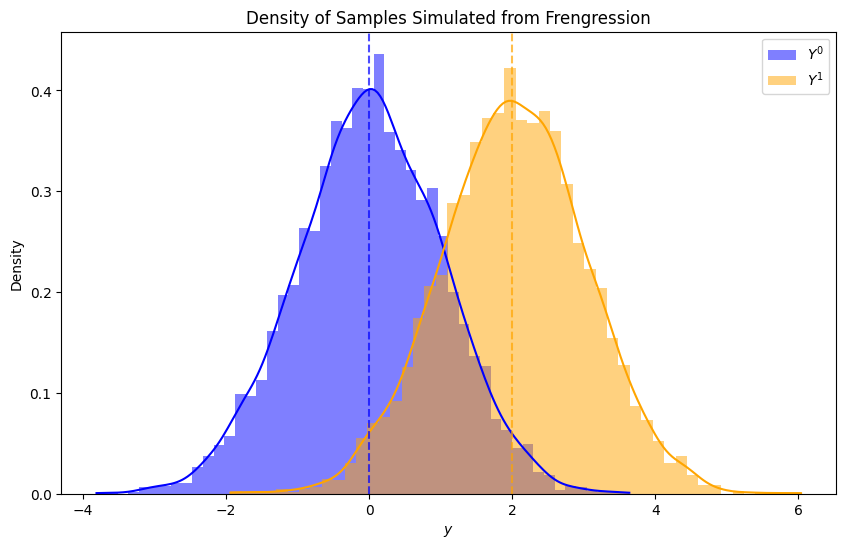

In [5]:
# Sample causal margins
x0_samples = model.sample_causal_margin(x=torch.tensor([[0]], dtype=torch.int32), sample_size=5000).numpy().flatten()
x1_samples = model.sample_causal_margin(x=torch.tensor([[1]], dtype=torch.int32), sample_size=5000).numpy().flatten()
sampled_x,sampled_y,sampled_z = model.sample_joint(sample_size=5000)
# Plot histograms and KDE
plt.figure(figsize=(10, 6))

# Histogram for x0_samples
sns.histplot(x0_samples, kde=True, color='blue', label='$Y^0$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Histogram for x1_samples
sns.histplot(x1_samples, kde=True, color='orange', label='$Y^1$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Highlight different supports (if needed)
# plt.axvline(min(x0_samples), color='blue', linestyle='--', alpha=0.7, label='$Y^0$ suppor end')
plt.axvline(x=0, color='blue', linestyle='--', alpha=0.7)
# plt.axvline(min(x1_samples), color='orange', linestyle='--', alpha=0.7, label='$Y^1$ support end')
plt.axvline(x=2, color='orange', linestyle='--', alpha=0.7)

# Add labels, legend, and title
plt.xlabel("$y$")
plt.ylabel("Density")
plt.title("Density of Samples Simulated from Frengression")
plt.legend()
plt.show()


In [5]:
margin_module = SpecifiedCausalMargin(ate=5, eta_dist="gaussian", x_dim=model.x_dim, noise_dim=model.noise_dim)
model.specify_causal(causal_margin=margin_module)


sampled_x_5x,sampled_y_5x,sampled_z_5x = model.sample_joint(sample_size=5000)
print('Diff-in-means: ', sampled_y_5x[sampled_x_5x==1].mean()-sampled_y_5x[sampled_x_5x==0].mean())
print('Proportion of sampled treated: ', (sampled_x_5x==1).sum()/sampled_x_5x.shape[0])
print('Proportion of true treated: ', (x_tr==1).sum()/x_tr.shape[0])

Diff-in-means:  tensor(4.8943)
Proportion of sampled treated:  tensor(0.4956)
Proportion of true treated:  tensor(0.5003)


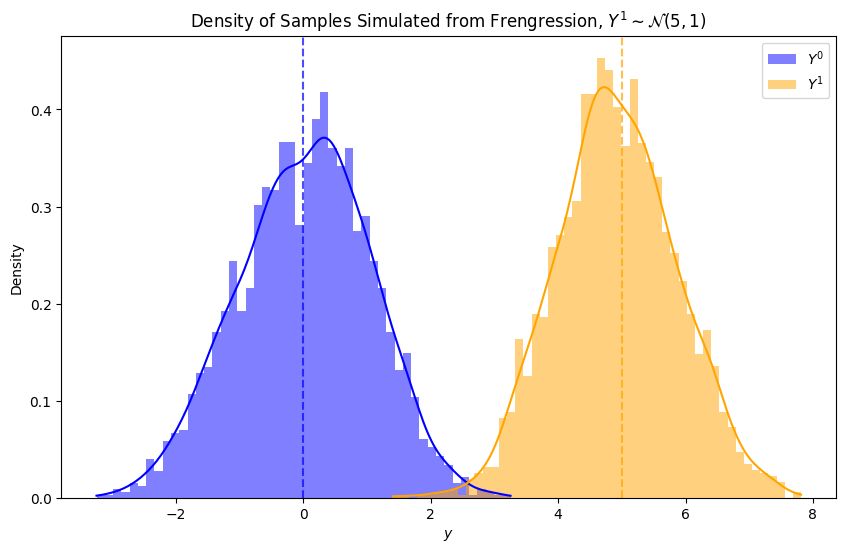

In [6]:
# Plot histograms and KDE
plt.figure(figsize=(10, 6))

# Histogram for x0_samples
sns.histplot(sampled_y_5x[sampled_x_5x==0], kde=True, color='blue', label='$Y^0$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Histogram for x1_samples
sns.histplot(sampled_y_5x[sampled_x_5x==1], kde=True, color='orange', label='$Y^1$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Highlight different supports (if needed)
# plt.axvline(min(x0_samples), color='blue', linestyle='--', alpha=0.7, label='$Y^0$ suppor end')
plt.axvline(x=0, color='blue', linestyle='--', alpha=0.7)
# plt.axvline(min(x1_samples), color='orange', linestyle='--', alpha=0.7, label='$Y^1$ support end')
plt.axvline(x=5, color='orange', linestyle='--', alpha=0.7)

# Add labels, legend, and title
plt.xlabel("$y$")
plt.ylabel("Density")
plt.title(R"Density of Samples Simulated from Frengression, $Y^1\sim\mathcal{N}(5,1)$")
plt.legend()
plt.show()


In [ ]:
margin_module = SpecifiedCausalMargin(ate=0, noise_dim=model.noise_dim, eta_dist = 'gaussian',x_dim = x_tr.shape[1])
model.specify_causal(causal_margin=margin_module)
# model.train_y(x_tr, z_tr, y_tr, num_iters=100000, lr=1e-4, print_every_iter=1000)
sampled_x_0x,sampled_y_0x,sampled_z_0x = model.sample_joint(sample_size=5000) 
print('Diff-in-means: ', sampled_y_0x[sampled_x_0x==1].mean()-sampled_y_0x[sampled_x_0x==0].mean())
print('Proportion of sampled treated: ', (sampled_x_0x==1).sum()/sampled_x_0x.shape[0])
print('Proportion of true treated: ', (x_tr==1).sum()/x_tr.shape[0])

Diff-in-means:  tensor(-0.0550)
Proportion of sampled treated:  tensor(0.4736)
Proportion of true treated:  tensor(0.5003)


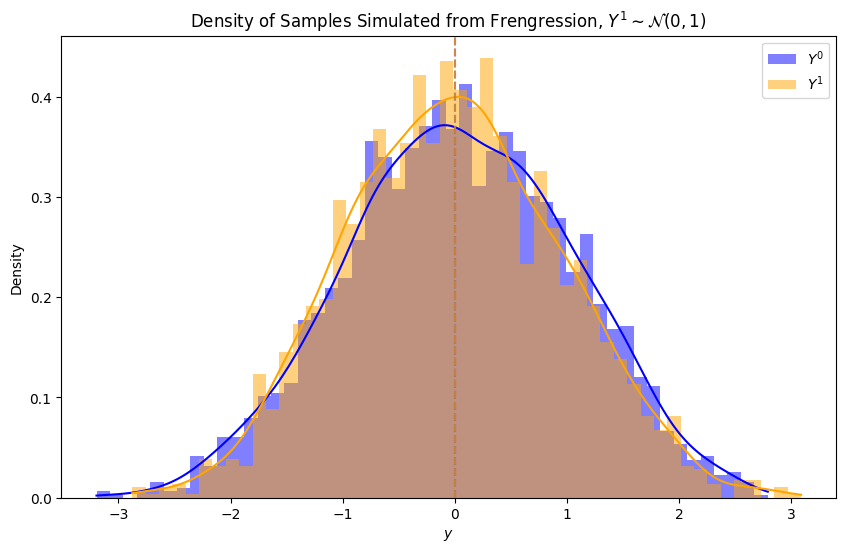

In [8]:
# Plot histograms and KDE
plt.figure(figsize=(10, 6))

# Histogram for x0_samples
sns.histplot(sampled_y_0x[sampled_x_0x==0], kde=True, color='blue', label='$Y^0$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Histogram for x1_samples
sns.histplot(sampled_y_0x[sampled_x_0x==1], kde=True, color='orange', label='$Y^1$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Highlight different supports (if needed)
# plt.axvline(min(x0_samples), color='blue', linestyle='--', alpha=0.7, label='$Y^0$ suppor end')
plt.axvline(x=0, color='blue', linestyle='--', alpha=0.7)
# plt.axvline(min(x1_samples), color='orange', linestyle='--', alpha=0.7, label='$Y^1$ support end')
plt.axvline(x=0, color='orange', linestyle='--', alpha=0.7)

# Add labels, legend, and title
plt.xlabel("$y$")
plt.ylabel("Density")
plt.title(R"Density of Samples Simulated from Frengression, $Y^1\sim\mathcal{N}(0,1)$")
plt.legend()
plt.show()


In [9]:
margin_module = SpecifiedCausalMargin(ate=2, noise_dim=model.noise_dim, eta_dist = 'laplace',x_dim = x_tr.shape[1])
model.specify_causal(causal_margin=margin_module)
# model.train_y(x_tr, z_tr, y_tr, num_iters=100000, lr=1e-4, print_every_iter=1000)
sampled_x_2x,sampled_y_2x,sampled_z_2x = model.sample_joint(sample_size=5000)
print('Diff-in-means: ', sampled_y_2x[sampled_x_2x==1].mean()-sampled_y_2x[sampled_x_2x==0].mean())
print('Proportion of sampled treated: ', (sampled_x_2x==1).sum()/sampled_x_2x.shape[0])
print('Proportion of true treated: ', (x_tr==1).sum()/x_tr.shape[0])

Diff-in-means:  tensor(1.9560)
Proportion of sampled treated:  tensor(0.4884)
Proportion of true treated:  tensor(0.5003)


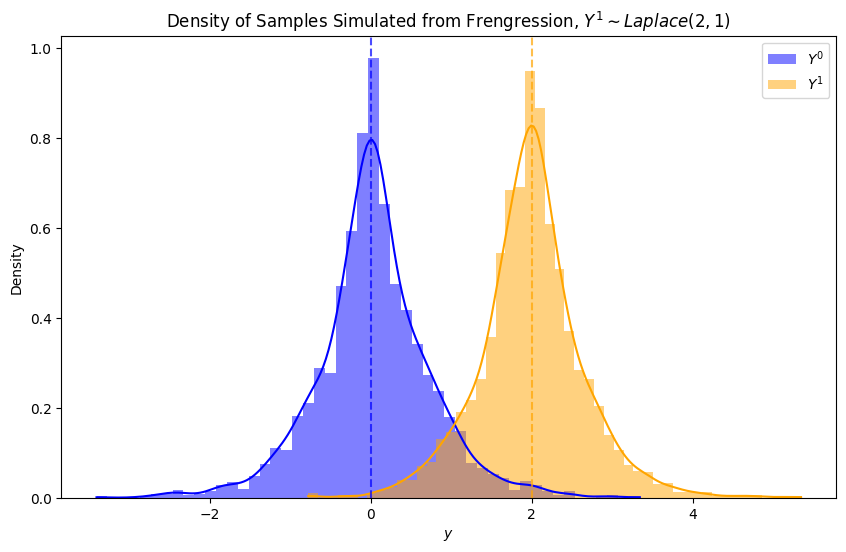

In [10]:
# Plot histograms and KDE
plt.figure(figsize=(10, 6))

# Histogram for x0_samples
sns.histplot(sampled_y_2x[sampled_x_2x==0], kde=True, color='blue', label='$Y^0$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Histogram for x1_samples
sns.histplot(sampled_y_2x[sampled_x_2x==1], kde=True, color='orange', label='$Y^1$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Highlight different supports (if needed)
# plt.axvline(min(x0_samples), color='blue', linestyle='--', alpha=0.7, label='$Y^0$ suppor end')
plt.axvline(x=0, color='blue', linestyle='--', alpha=0.7)
# plt.axvline(min(x1_samples), color='orange', linestyle='--', alpha=0.7, label='$Y^1$ support end')
plt.axvline(x=2, color='orange', linestyle='--', alpha=0.7)

# Add labels, legend, and title
plt.xlabel("$y$")
plt.ylabel("Density")
plt.title(R"Density of Samples Simulated from Frengression, $Y^1\sim Laplace(2,1)$")
plt.legend()
plt.show()


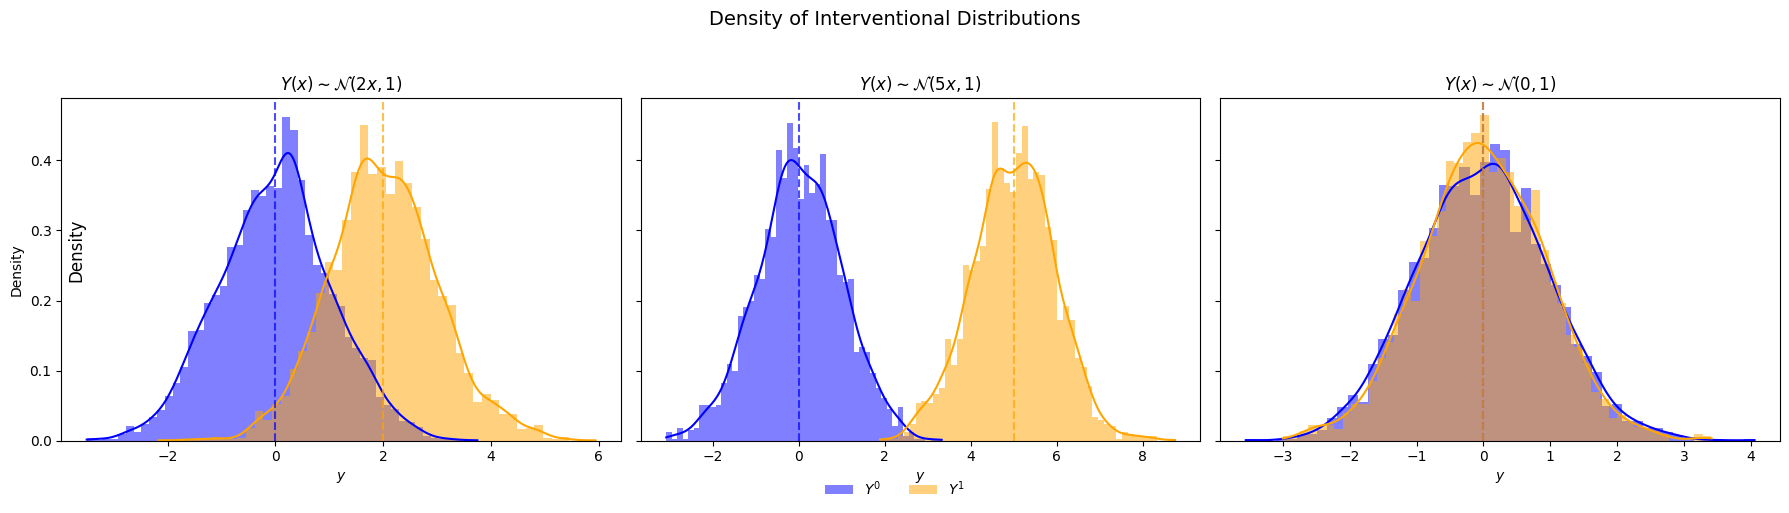

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# assume x0_samples, x1_samples, sampled_y_5x, sampled_x_5x, sampled_y_0x, sampled_x_0x
# are already in your namespace as from your code above

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# common styling
plot_args = dict(kde=True, stat="density", bins=50, edgecolor=None, alpha=0.5)

# 1) causal margins
sns.histplot(x0_samples, color='blue', label='$Y^0$', ax=axes[0], **plot_args)
sns.histplot(x1_samples, color='orange', label='$Y^1$', ax=axes[0], **plot_args)
axes[0].axvline(0, linestyle='--', color='blue', alpha=0.7)
axes[0].axvline(2, linestyle='--', color='orange', alpha=0.7)
axes[0].set_title("$Y(x)\sim\mathcal{N}(2x,1)$")
axes[0].set_xlabel("$y$")

# 2) joint sample with ATE=5
sns.histplot(sampled_y_5x[sampled_x_5x==0], color='blue', ax=axes[1], **plot_args)
sns.histplot(sampled_y_5x[sampled_x_5x==1], color='orange', ax=axes[1], **plot_args)
axes[1].axvline(0, linestyle='--', color='blue', alpha=0.7)
axes[1].axvline(5, linestyle='--', color='orange', alpha=0.7)
axes[1].set_title(r"$Y(x)\sim\mathcal{N}(5x,1)$")
axes[1].set_xlabel("$y$")

# 3) joint sample with ATE=0
sns.histplot(sampled_y_0x[sampled_x_0x==0], color='blue', ax=axes[2], **plot_args)
sns.histplot(sampled_y_0x[sampled_x_0x==1], color='orange', ax=axes[2], **plot_args)
axes[2].axvline(0, linestyle='--', color='blue', alpha=0.7)
axes[2].axvline(0, linestyle='--', color='orange', alpha=0.7)
axes[2].set_title(r"$Y(x)\sim\mathcal{N}(0,1)$")
axes[2].set_xlabel("$y$")

# share one y-label
fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=12)
handles, labels = axes[0].get_legend_handles_labels()
# build a single legend (get handles from the first axis)
fig.legend(
    handles, labels,
    loc="lower center",
    ncol=len(handles),
    frameon=False,
    fontsize=10,
    bbox_to_anchor=(0.5, -0.02)
)

# fig.legend(handles, labels, loc='lower center', ncol=2, frameon=False, fontsize=12)
plt.suptitle(R"Density of Interventional Distributions", fontsize=14, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space up top for the legend
plt.show()


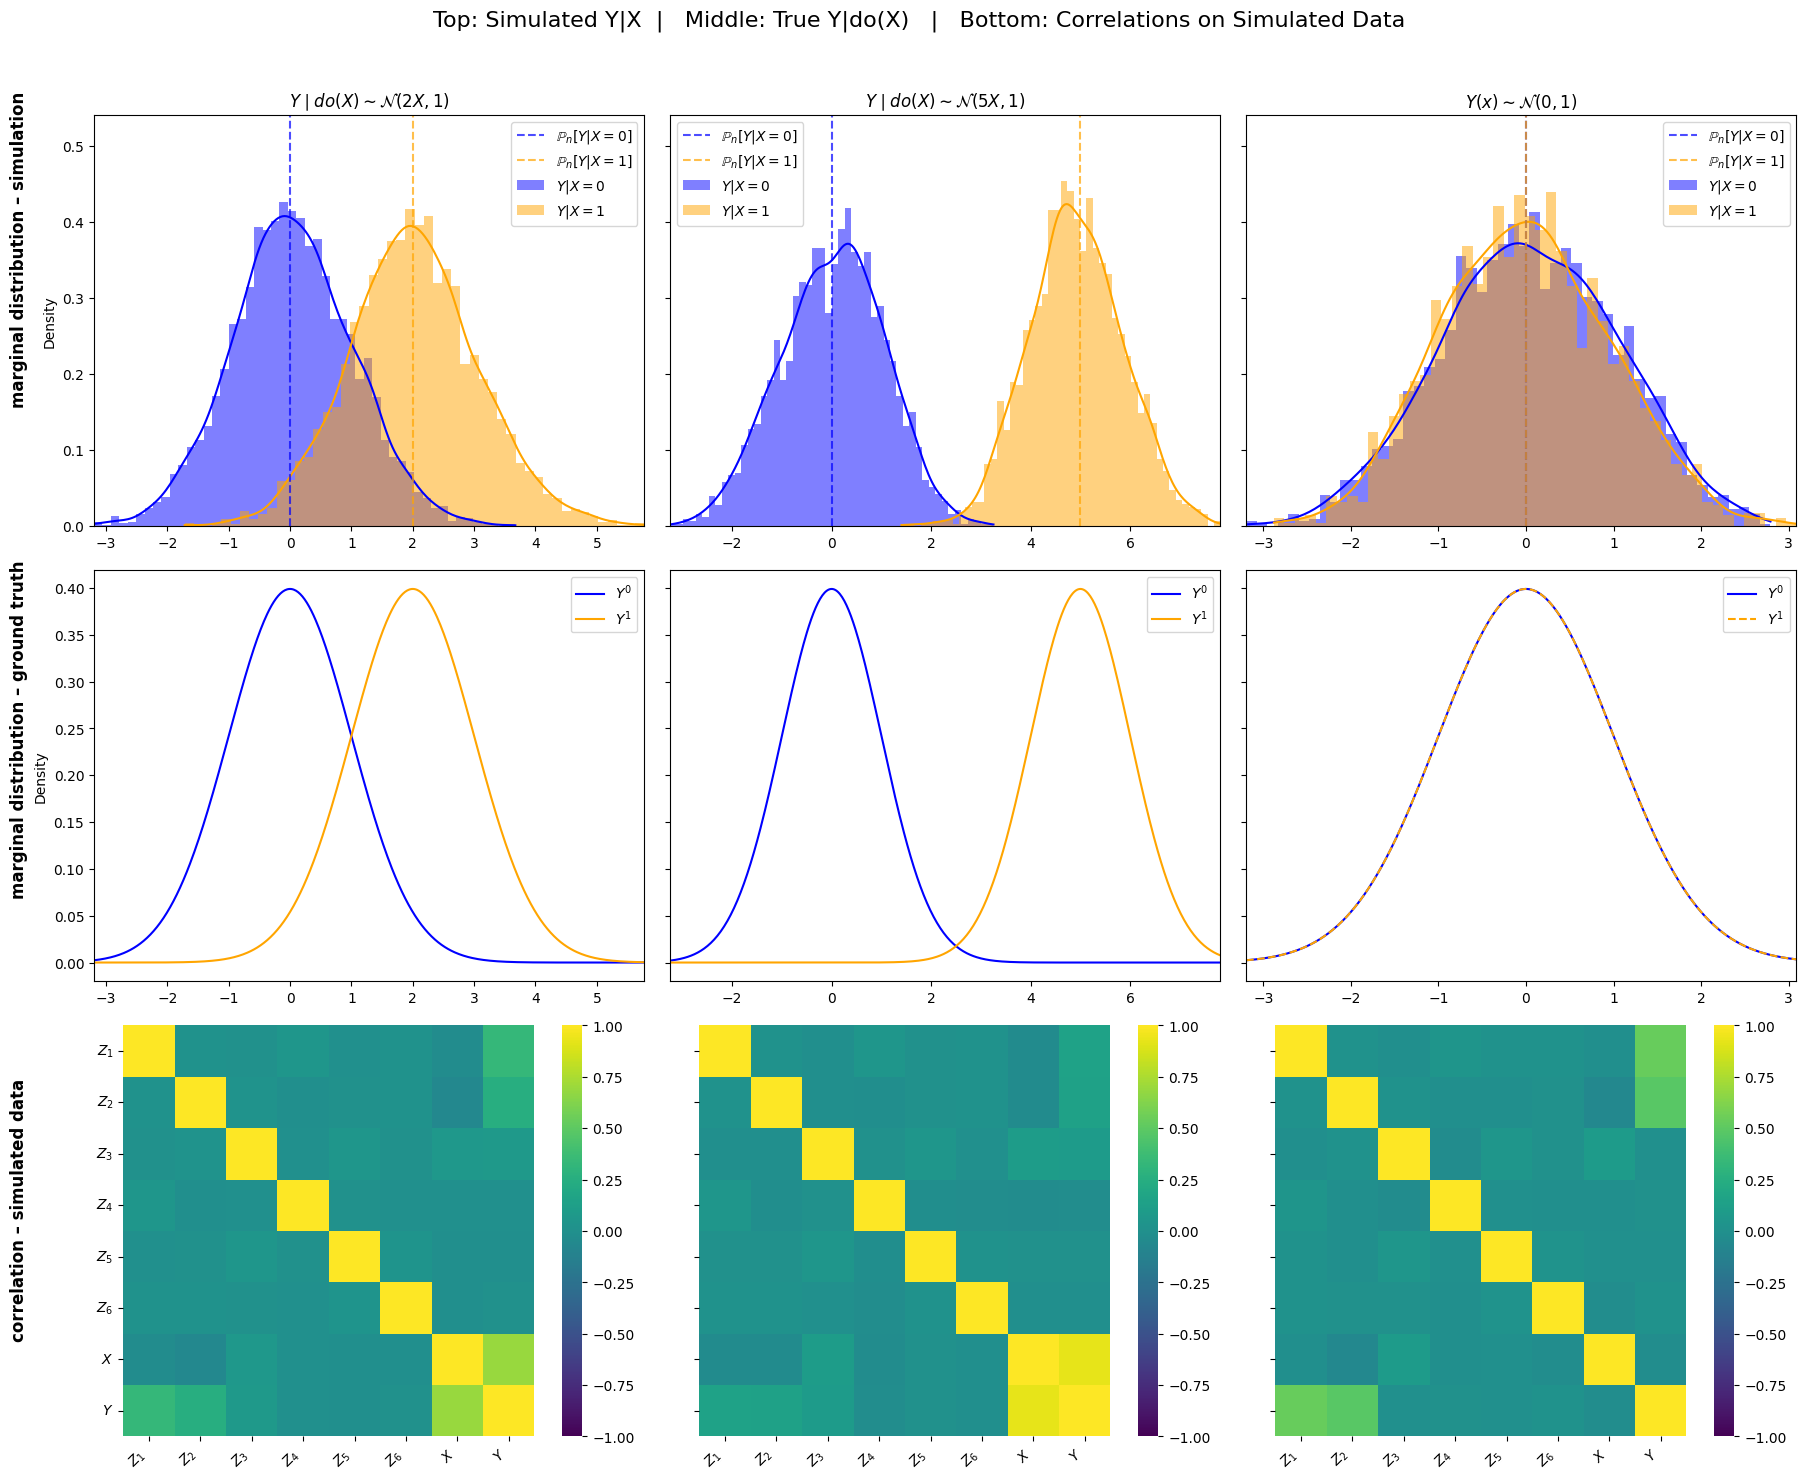

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(18, 15), sharey='row')

# 1) Rotated row titles
row_labels = [
    "marginal distribution – simulation",
    "marginal distribution – ground truth",
    "correlation – simulated data"
]
y_positions = [0.82, 0.50, 0.18]
for lab, y in zip(row_labels, y_positions):
    fig.text(
        x=0.0, y=y, s=lab,
        va='center', ha='center',
        rotation=90, fontsize=12, weight='bold'
    )

# 2) Compute per-column x-limits
y0 = np.concatenate([np.ravel(x0_samples), np.ravel(x1_samples)])
xmin0, xmax0 = y0.min(), y0.max()
y1 = np.ravel(sampled_y_5x); xmin1, xmax1 = y1.min(), y1.max()
y2 = np.ravel(sampled_y_0x); xmin2, xmax2 = y2.min(), y2.max()

# Common histogram + KDE styling
hist_args = dict(
    stat="density",
    bins=50,
    kde=True,           # ← fit & plot KDE
    edgecolor=None,
    alpha=0.5
)

### Row 1: simulated marginals ###
# Col 0: do(X)=0 vs do(X)=1
sns.histplot(x0_samples, color='blue', label='$Y|X=0$', ax=axes[0,0], **hist_args)
sns.histplot(x1_samples, color='orange', label='$Y|X=1$', ax=axes[0,0], **hist_args)
# dashed lines at the sample means
axes[0,0].axvline(0, linestyle='--', color='blue',
                  label=r'$\mathbb{P}_n[Y|X=0]$', alpha=0.7)
axes[0,0].axvline(2, linestyle='--', color='orange',
                  label=r'$\mathbb{P}_n[Y|X=1]$', alpha=0.7)
axes[0,0].set_title(r"$Y\mid do(X)\sim\mathcal{N}(2X,1)$")
axes[0,0].set_xlim(xmin0, xmax0)
axes[0,0].legend()
axes[0,0].set_ylabel("Density")

# Col 1: ATE=5
sns.histplot(sampled_y_5x[sampled_x_5x==0], color='blue',
             label='$Y|X=0$', ax=axes[0,1], **hist_args)
sns.histplot(sampled_y_5x[sampled_x_5x==1], color='orange',
             label='$Y|X=1$', ax=axes[0,1], **hist_args)
axes[0,1].axvline(0, linestyle='--', color='blue',
                  label=r'$\mathbb{P}_n[Y|X=0]$', alpha=0.7)
axes[0,1].axvline(5, linestyle='--', color='orange',
                  label=r'$\mathbb{P}_n[Y|X=1]$', alpha=0.7)
axes[0,1].set_title(r"$Y\mid do(X)\sim\mathcal{N}(5X,1)$")
axes[0,1].set_xlim(xmin1, xmax1)
axes[0,1].legend()

# Col 2: ATE=0
sns.histplot(sampled_y_0x[sampled_x_0x==0], color='blue',
             label='$Y|X=0$', ax=axes[0,2], **hist_args)
sns.histplot(sampled_y_0x[sampled_x_0x==1], color='orange',
             label='$Y|X=1$', ax=axes[0,2], **hist_args)
axes[0,2].axvline(0, linestyle='--', color='blue',
                  label=r'$\mathbb{P}_n[Y|X=0]$', alpha=0.7)
axes[0,2].axvline(0, linestyle='--', color='orange',
                  label=r'$\mathbb{P}_n[Y|X=1]$', alpha=0.7)
axes[0,2].set_title(r"$Y(x)\sim\mathcal{N}(0,1)$")
axes[0,2].set_xlim(xmin2, xmax2)
axes[0,2].legend()

# ensure all three histograms share the same vertical range
max_density = 0.54
for ax in axes[0]:
    ax.set_ylim(0, max_density)


### Row 2: ground-truth marginals ###
ygrid0 = np.linspace(xmin0, xmax0, 500)
ygrid1 = np.linspace(xmin1, xmax1, 500)
ygrid2 = np.linspace(xmin2, xmax2, 500)

# Col 0
axes[1,0].plot(ygrid0, norm.pdf(ygrid0, loc=0, scale=1),
               label='$Y^0$', color='blue')
axes[1,0].plot(ygrid0, norm.pdf(ygrid0, loc=2, scale=1),
               label='$Y^1$', color='orange')
axes[1,0].set_xlim(xmin0, xmax0)
axes[1,0].legend()
axes[1,0].set_ylabel("Density")

# Col 1
axes[1,1].plot(ygrid1, norm.pdf(ygrid1, loc=0, scale=1),
               label='$Y^0$', color='blue')
axes[1,1].plot(ygrid1, norm.pdf(ygrid1, loc=5, scale=1),
               label='$Y^1$', color='orange')
axes[1,1].set_xlim(xmin1, xmax1)
axes[1,1].legend()

# Col 2
axes[1,2].plot(ygrid2, norm.pdf(ygrid2, loc=0, scale=1),
               label='$Y^0$', color='blue')
axes[1,2].plot(ygrid2, norm.pdf(ygrid2, loc=0, scale=1),
               label='$Y^1$', color='orange', linestyle='--')
axes[1,2].set_xlim(xmin2, xmax2)
axes[1,2].legend()


### Row 3: correlation heatmaps of (Z₁,…,Zₚ, X, Y) ###
def corr_heatmap(z, x, y, ax):
    z_arr = np.asarray(z)
    x_arr = np.asarray(x).ravel()
    y_arr = np.asarray(y).ravel()
    n, p = z_arr.shape
    df = pd.DataFrame(z_arr, columns=[f'Z_{i+1}' for i in range(p)])
    df['X'] = x_arr
    df['Y'] = y_arr
    corr = df.corr()
    sns.heatmap(
        corr, annot=False, cmap='viridis',
        vmin=-1, vmax=1, square=True, ax=ax
    )
    labels = [rf'$Z_{{{i+1}}}$' for i in range(p)] + ['$X$', '$Y$']
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticklabels(labels, rotation=0)

# Col 0: combine marginals
corr_heatmap(sampled_z, sampled_x, sampled_y, axes[2,0])

# Col 1: joint ATE=5
corr_heatmap(sampled_z_5x, sampled_x_5x, sampled_y_5x, axes[2,1])

# Col 2: joint ATE=0
corr_heatmap(sampled_z_0x, sampled_x_0x, sampled_y_0x, axes[2,2])

# Final layout
plt.suptitle(
    "Top: Simulated Y|X  |   Middle: True Y|do(X)   |   Bottom: Correlations on Simulated Data",
    fontsize=16, y=0.98
)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


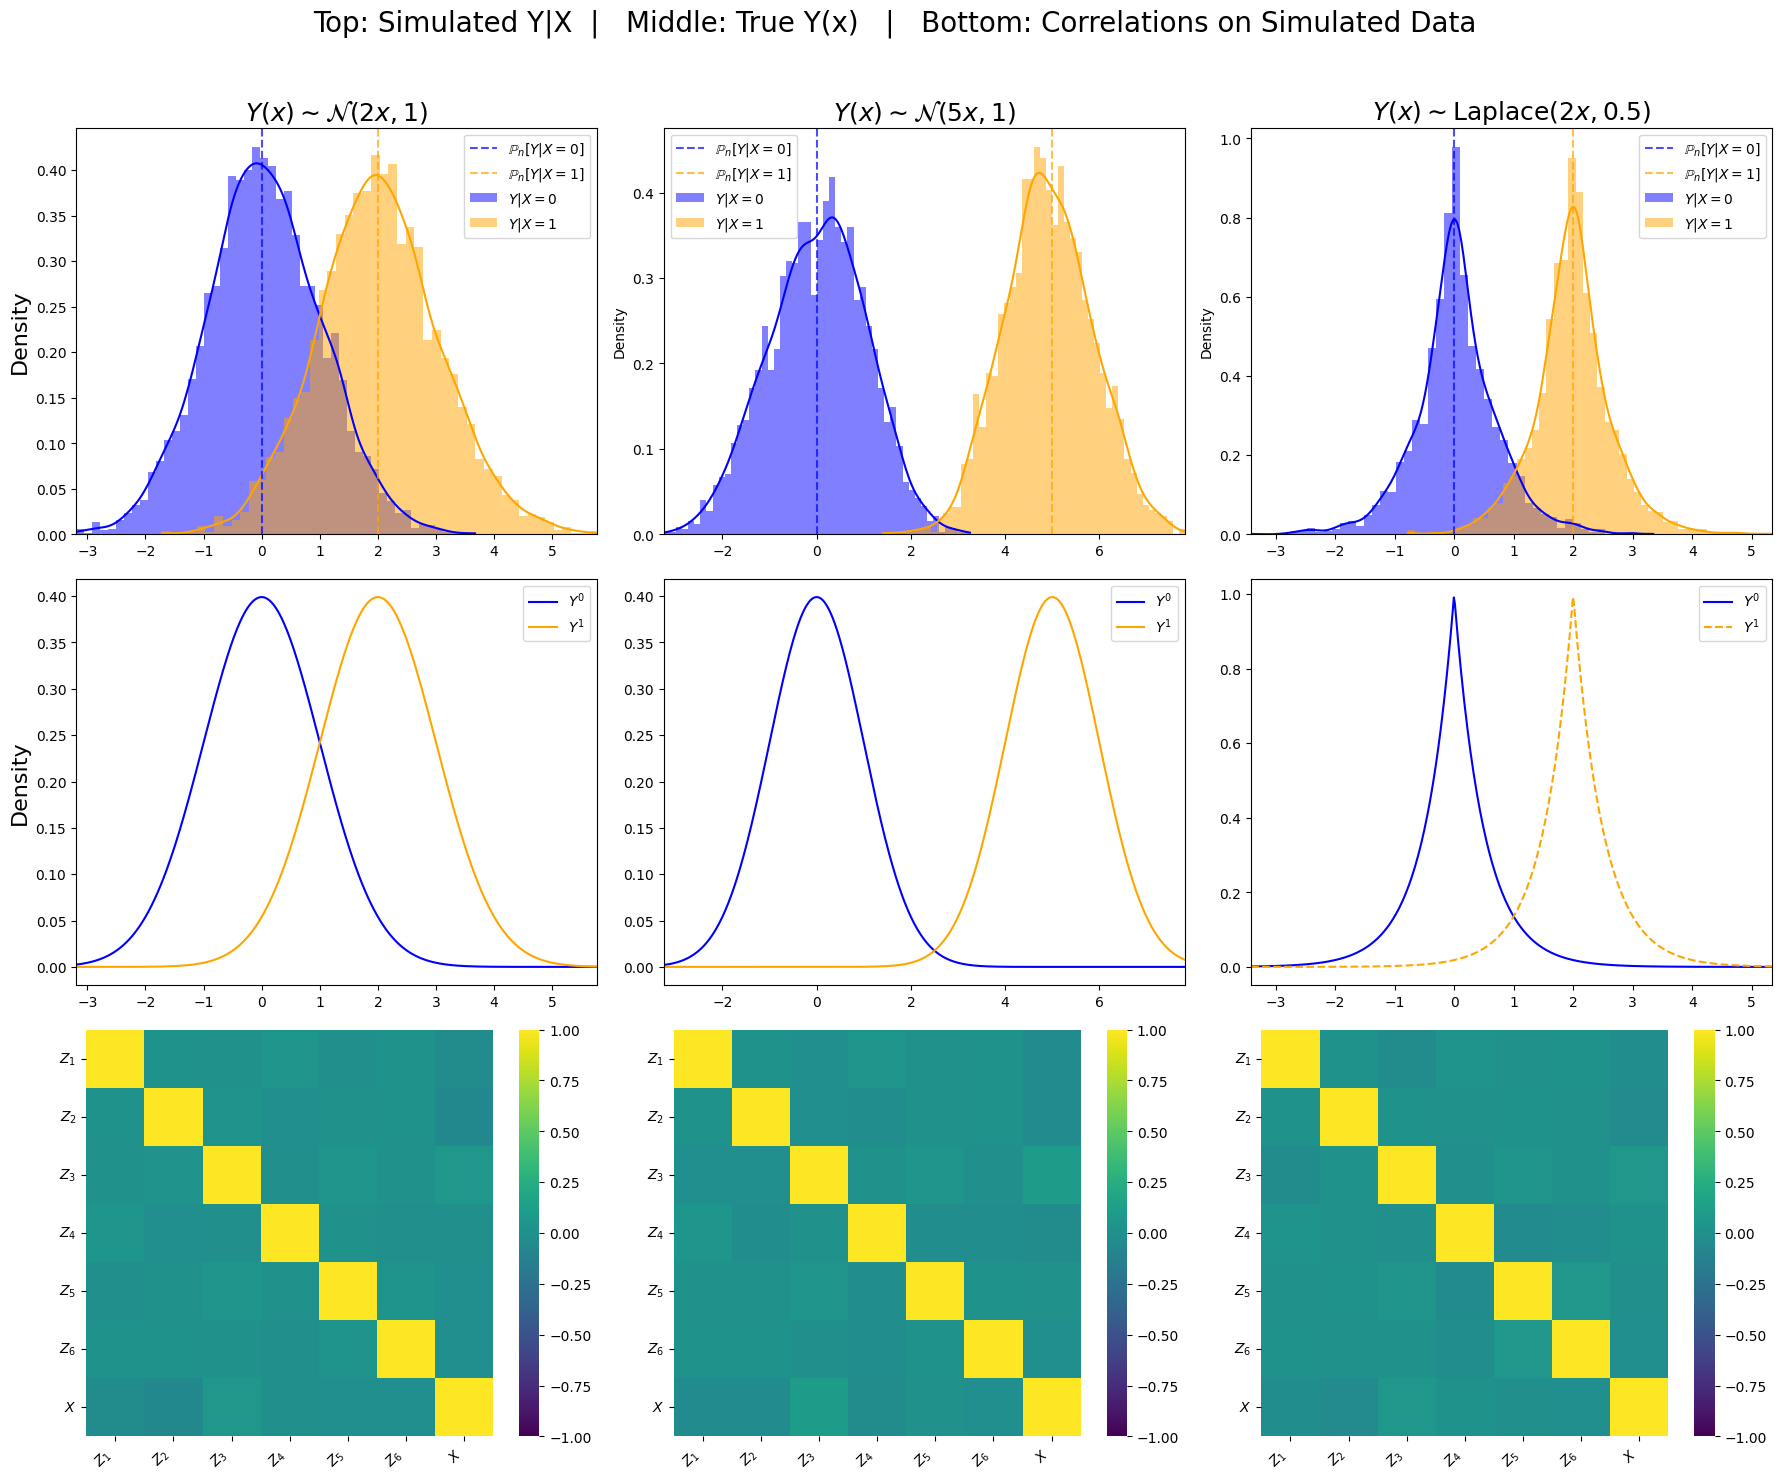

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, laplace

# — your data arrays must already be defined — 
# x0_samples, x1_samples               
# sampled_x_5x, sampled_y_5x           
# sampled_x_0x, sampled_y_0x           
# z0_samples, z1_samples               # shape (n_obs, p)
# sampled_z_5x, sampled_z_0x           # shape (n_obs, p)
# sampled_z, sampled_x                 # combined marginals for col-0

fig, axes = plt.subplots(3, 3, figsize=(18, 15), sharey=False)


# Compute per-column x-limits
y0 = np.concatenate([np.ravel(x0_samples), np.ravel(x1_samples)])
xmin0, xmax0 = y0.min(), y0.max()
y1 = np.ravel(sampled_y_5x); xmin1, xmax1 = y1.min(), y1.max()
y2 = np.ravel(sampled_y_2x); xmin2, xmax2 = y2.min(), y2.max()

# Common histogram + KDE styling
hist_args = dict(
    stat="density",
    bins=50,
    kde=True,           # fit & plot KDE
    edgecolor=None,
    alpha=0.5
)

### Row 1: simulated marginals ###
# Col 0
sns.histplot(x0_samples, color='blue', label='$Y|X=0$', ax=axes[0,0], **hist_args)
sns.histplot(x1_samples, color='orange', label='$Y|X=1$', ax=axes[0,0], **hist_args)
axes[0,0].axvline(0, linestyle='--', color='blue',
                  label=r'$\mathbb{P}_n[Y|X=0]$', alpha=0.7)
axes[0,0].axvline(2, linestyle='--', color='orange',
                  label=r'$\mathbb{P}_n[Y|X=1]$', alpha=0.7)
axes[0,0].set_title(r"$Y(x) \sim\mathcal{N}(2x,1)$", fontsize=18)
axes[0,0].set_xlim(xmin0, xmax0)
axes[0,0].legend()
axes[0,0].set_ylabel("Density",fontsize=16)

# Col 1
sns.histplot(sampled_y_5x[sampled_x_5x==0], color='blue',
             label='$Y|X=0$', ax=axes[0,1], **hist_args)
sns.histplot(sampled_y_5x[sampled_x_5x==1], color='orange',
             label='$Y|X=1$', ax=axes[0,1], **hist_args)
axes[0,1].axvline(0, linestyle='--', color='blue',
                  label=r'$\mathbb{P}_n[Y|X=0]$', alpha=0.7)
axes[0,1].axvline(5, linestyle='--', color='orange',
                  label=r'$\mathbb{P}_n[Y|X=1]$', alpha=0.7)
axes[0,1].set_title(r"$Y(x)\sim\mathcal{N}(5x,1)$", fontsize=18)
axes[0,1].set_xlim(xmin1, xmax1)
axes[0,1].legend()

# Col 2
sns.histplot(sampled_y_2x[sampled_x_2x==0], color='blue',
             label='$Y|X=0$', ax=axes[0,2], **hist_args)
sns.histplot(sampled_y_2x[sampled_x_2x==1], color='orange',
             label='$Y|X=1$', ax=axes[0,2], **hist_args)
axes[0,2].axvline(0, linestyle='--', color='blue',
                  label=r'$\mathbb{P}_n[Y|X=0]$', alpha=0.7)
axes[0,2].axvline(2, linestyle='--', color='orange',
                label=r'$\mathbb{P}_n[Y|X=1]$', alpha=0.7)
axes[0,2].set_title(r"$Y(x)\sim \operatorname{Laplace}(2x,0.5)$",fontsize=18)
axes[0,2].set_xlim(xmin2, xmax2)
axes[0,2].legend()



### Row 2: ground-truth marginals ###
ygrid0 = np.linspace(xmin0, xmax0, 500)
ygrid1 = np.linspace(xmin1, xmax1, 500)
ygrid2 = np.linspace(xmin2, xmax2, 500)

# Col 0
axes[1,0].plot(ygrid0, norm.pdf(ygrid0, loc=0, scale=1),
               label='$Y^0$', color='blue')
axes[1,0].plot(ygrid0, norm.pdf(ygrid0, loc=2, scale=1),
               label='$Y^1$', color='orange')
axes[1,0].set_xlim(xmin0, xmax0)
axes[1,0].legend()
axes[1,0].set_ylabel("Density", fontsize=16)

# Col 1
axes[1,1].plot(ygrid1, norm.pdf(ygrid1, loc=0, scale=1),
               label='$Y^0$', color='blue')
axes[1,1].plot(ygrid1, norm.pdf(ygrid1, loc=5, scale=1),
               label='$Y^1$', color='orange')
axes[1,1].set_xlim(xmin1, xmax1)
axes[1,1].legend()

# Col 2
axes[1,2].plot(ygrid2, laplace.pdf(ygrid2, loc=0, scale=0.5),
               label='$Y^0$', color='blue')
axes[1,2].plot(ygrid2, laplace.pdf(ygrid2, loc=2, scale=0.5),
               label='$Y^1$', color='orange', linestyle='--')
axes[1,2].set_xlim(xmin2, xmax2)
axes[1,2].legend()


### Row 3: correlation heatmaps of (Z₁,…,Zₚ, X) ###
def corr_heatmap(z, x, ax):
    z_arr = np.asarray(z)
    x_arr = np.asarray(x).ravel()
    n, p = z_arr.shape
    df = pd.DataFrame(z_arr, columns=[f'Z_{i+1}' for i in range(p)])
    df['X'] = x_arr
    corr = df.corr()
    sns.heatmap(
        corr, annot=False,
        cmap='viridis', vmin=-1, vmax=1,
        square=True, ax=ax
    )
    labels = [rf'$Z_{{{i+1}}}$' for i in range(p)] + ['$X$']
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticklabels(labels, rotation=0)


# Col 0: combined marginals
corr_heatmap(sampled_z, sampled_x, axes[2,0])

# Col 1: joint ATE=5
corr_heatmap(sampled_z_5x, sampled_x_5x, axes[2,1])

# Col 2: joint ATE=0
corr_heatmap(sampled_z_2x, sampled_x_2x, axes[2,2])

# Final layout
plt.suptitle(
    "Top: Simulated Y|X  |   Middle: True Y(x)   |   Bottom: Correlations on Simulated Data",
    fontsize=20, y=0.98
)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
